In [1]:
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Customer Churn Rate

**Data Description**


| Feature | Description |
| :- | -: |
| churned | whether the custumer churned (1) or not (0) |
| customer_code | unique customer identification code |
| co_name | company name |
| total_spend | the sum of the total spent over the year | 
| week_minus_4 <br> week_minus_3 <br> week_minus_2 <br> last_week | weekly spend as a percentage of the average spend |
| 4-3_delta <br> 3-2_delta <br> 2-1_delta | weekly change relative to the average spend |

## Data Exploration

In [2]:
# load the data
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/churn_data.csv'
data = pd.read_csv(path, index_col = 'id')

#viewing dataset
data.head()

,churned,customer_code,co_name,total_spend,week_minus_4,week_minus_3,week_minus_2,last_week,4-3_delta,3-2_delta,2-1_delta
id,,,,,,,,,,,
1,0,1826,Hoffman Martinez and Chandler,68567.34,0.81,0.02,0.74,1.45,-0.79,0.72,0.71
2,0,772,Lee Martin and Escobar,74335.27,1.87,1.02,1.29,1.19,-0.85,0.27,-0.10
3,0,479,Hobbs Mcdaniel and Baker,48746.22,1.21,0.70,1.04,2.12,-0.51,0.34,1.08
4,0,1692,Williams-Harris,64416.70,0.75,2.08,2.40,2.02,1.33,0.32,-0.38
5,0,2578,Beck-Snyder,71623.20,2.33,0.66,1.97,1.60,-1.67,1.31,-0.37


In [3]:
#dataframe size
data.shape

(2999, 11)

In [4]:
#column data type
data.dtypes

churned            int64
customer_code      int64
co_name           object
total_spend      float64
week_minus_4     float64
week_minus_3     float64
week_minus_2     float64
last_week        float64
4-3_delta        float64
3-2_delta        float64
2-1_delta        float64
dtype: object

In [5]:
# churned vs not churned (target)
data.churned.value_counts()

churned
0    2833
1     166
Name: count, dtype: int64

## Model

In [6]:
#Defining X and Y
X_col = ['total_spend', 'week_minus_4', 'week_minus_3', 'week_minus_2', 'last_week', '4-3_delta', '3-2_delta', '2-1_delta']
X = data[X_col]
y = data.churned

In [7]:
#splitting training and test data.
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
#defining model
reg = RandomForestClassifier(n_jobs=-1)

- **min_samples_leaf** minimum samples required on output leaf node
- **min_samples_split** minimum samples required in node to split
- **n_estimators** number of trees
- **max_depth** max depth of the trees. prevents overfitting

In [9]:
#establishing grid search parameters
parameters = {"min_samples_leaf" : [1, 4],
              "min_samples_split" : [2, 4], 
              "n_estimators" : [10, 25, 50, 100],
              "max_depth" : [2,5,10,15]
             }

In [10]:
#defining grid
grid = GridSearchCV(reg, parameters,cv=10,scoring='accuracy',n_jobs=-1,verbose=True)

In [11]:
#fitting grid search. Uses cross validation and tries each parameter combo
grid.fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=True)

In [12]:
#Finding grid accuracy score
grid.best_score_

0.9510912698412698

In [13]:
#parameters that achieved the best accuracy score
grid.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}

In [14]:
y_test_pred = grid.predict(X_test)

In [15]:
# confusion matrix
rf_confusion = confusion_matrix(y_test,y_test_pred)
rf_confusion

array([[694,  13],
       [ 31,  12]])

In [16]:
# accuracy score
rf_accuracy = accuracy_score(y_test,y_test_pred)
rf_accuracy

0.9413333333333334

In [17]:
rf_precision = precision_score(y_test,y_test_pred)
rf_precision

0.48

In [18]:
# recall
rf_recall = recall_score(y_test,y_test_pred)
rf_recall

0.27906976744186046

<Axes: >

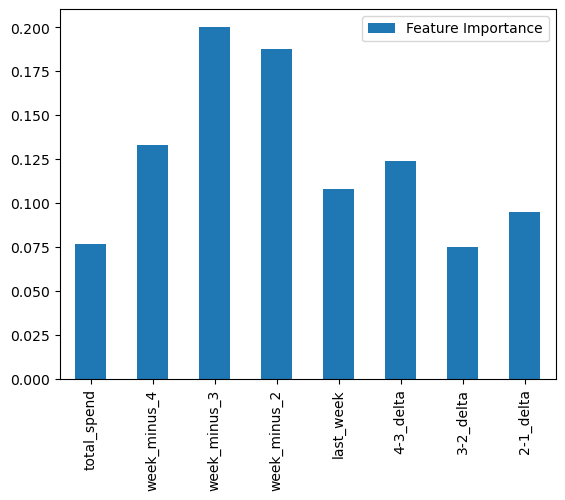

In [19]:
#finding most important features
pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X.columns, columns=['Feature Importance']).plot.bar()

The model suggests higher weekly spend as a percentage of the average spend 2 or 3 weeks ago indicates a customer is more likely to churn.

## XGBoost Classification

Test if XGB can improve accuracy

In [20]:
#defining model
xgb_model = xgb.XGBClassifier(objective="binary:logistic")

- **colsample_bytree** proportion of the sample used to train the tree. Similar to a random forest. 
- **Gamma** Required loss reduction to make another node. The larger gamma is, the more conservative the algorithm will be. Range: [0,∞]
- **learning_rate** Boosting assigns feature weights. The learning rate shrinks those weights to prevent overfitting. Step size shrinkage. Prevents overfitting. range: [0,1]
- **max_depth** Maximum depth of a tree. Larger number of trees can cause overfitting. 0 means no limit. range: [0,∞]

In [21]:
#establishing grid search parameters
parameters = {
    'colsample_bytree' : [0.7, 0.4, 0.2],
    'gamma' : [0, 0.3, 0.5],
    "learning_rate": [.05, .15, .25],
    "max_depth": [2, 4, 6]
}

In [22]:
# Grid Search
grid = GridSearchCV(xgb_model,parameters,cv=5,scoring='neg_root_mean_squared_error',n_jobs=-1,verbose=True)

In [23]:
#Fitting model (lots of parameters and takes a while)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.4, 0.2],
                         'gamma': [0, 0.3, 0.5],
                         'learning_rate': [0.05, 0.15, 0.25],
                         'max_depth': [2, 4, 6]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [24]:
#Grids best accuracy score
grid.best_score_

-0.21185579041500135

In [25]:
#parameters used to acheive best accuracy score
grid.best_params_

{'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.25, 'max_depth': 2}

In [26]:
#using model to predict y_test values
y_test_pred = grid.predict(X_test)

### Model Evaluation

In [27]:
accuracy_score(y_test,y_test_pred)

0.9373333333333334

In [28]:
rf_accuracy

0.9413333333333334

In [29]:
precision_score(y_test,y_test_pred)

0.4230769230769231

In [30]:
rf_precision

0.48

In [31]:
recall_score(y_test,y_test_pred)

0.2558139534883721

In [32]:
rf_recall

0.27906976744186046

In [33]:
confusion_matrix(y_test, y_test_pred)

array([[692,  15],
       [ 32,  11]])

In [34]:
rf_confusion

array([[694,  13],
       [ 31,  12]])

Random Forest is the more accurate model